# User-level graph

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

from utils import ROOTPATH, build_df_year, generate_index

In [2]:
df2012 = build_df_year(2012)
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012


## basic descriptives
### per-user submissions / subreddits

In [3]:
# visualize distributions 

def plot_user_subr_distribution(dfyear, year):
    user_aggr = dfyear.groupby("author").agg({"subreddit": lambda x: set(list(x))}).reset_index()
    user_aggr["n_subr"] = user_aggr["subreddit"].map(lambda x: len(x))
    plt.hist(user_aggr["n_subr"], bins=15, color="#FF4500")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# of subreddits", fontsize=14)
    plt.ylabel("# of users", fontsize=14)
    plt.savefig(ROOTPATH + f"output/fig/user_subreddit_distribution_{year}.svg")
    return user_aggr

def plot_user_subm_distribution(dfyear, year):
    user_aggr = dfyear.groupby("author").agg({"submission_id": lambda x: set(list(x))}).reset_index()
    user_aggr["n_subm"] = user_aggr["submission_id"].map(lambda x: len(x))
    plt.hist(user_aggr["n_subm"], bins=15, color="#FF4500")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# of submissions", fontsize=14)
    plt.ylabel("# of users", fontsize=14)
    plt.savefig(ROOTPATH + f"output/fig/user_submission_distribution_{year}.svg")
    return user_aggr

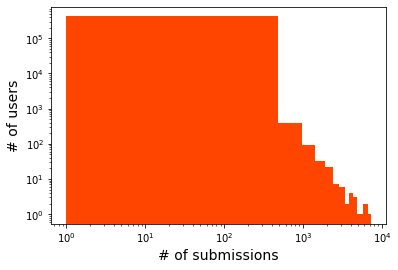

In [4]:
user_aggr_subm2012 = plot_user_subm_distribution(df2012, "2012")

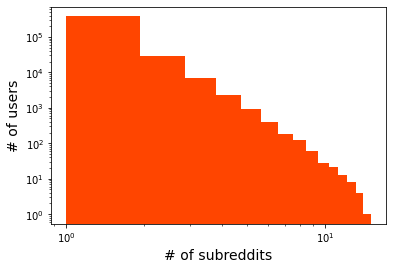

In [5]:
user_aggr_subr2012 = plot_user_subr_distribution(df2012, "2012")

## subsetting: only look at active multi-subreddit users

In [6]:
def subset(user_aggr_submyear, user_aggr_subryear, dfyear):
    ACTIVEUSERS = user_aggr_submyear[user_aggr_submyear["n_subm"]>=10].author.unique()
    MULTICOMMUSERS = user_aggr_subryear[user_aggr_subryear["n_subr"]>=2].author.unique()
    SUBSETUSERS = list(set(ACTIVEUSERS) & set(MULTICOMMUSERS))
    print("subset size:", len(SUBSETUSERS))
    dfyear_subset = dfyear[dfyear["author"].isin(SUBSETUSERS)].copy()
    return dfyear_subset

In [7]:
df2012_subset = subset(user_aggr_subm2012, user_aggr_subr2012, df2012)

subset size: 19124


## build user graph:

- node: user
- link: whether two users co-occur in a submission
    - weight: number of co-occurrences

In [8]:
def build_user_graph(dfyear_subset):
    subm_aggr = dfyear_subset.groupby("submission_id").agg({"author": lambda x: set(list(x))}).reset_index()
    subm_aggr["n_user"] = subm_aggr["author"].map(lambda x: len(x))
    subm_aggr = subm_aggr[subm_aggr["n_user"]>1].reset_index().drop(columns=["index"])  
    
    user_edges = {}
    print("recording edges...")
    for i,row in subm_aggr.iterrows():
        users = list(row["author"])
        if i%10000==0: print(" - progress:", i/len(subm_aggr))
        userpairs = [*combinations(users,2)]
        for i,up in enumerate(userpairs):
            u1 = min(user2index[up[0]],user2index[up[1]])
            u2 = max(user2index[up[0]],user2index[up[1]])
            try:
                user_edges[(u1, u2)] += 1
            except:
                user_edges[(u1, u2)] = 1
                
    print("building graph...")       
    userg = nx.Graph()
    for p,w in user_edges.items():
        userg.add_edge(p[0], p[1], weight=w)
    
    print("graph descriptives:")
    print(" - # of nodes:", len(userg.nodes()))
    print(" - # of edges:", len(userg.edges()))
    return user_edges, userg

In [ ]:
user_edges2012, userg2012 = build_user_graph(df2012_subset)

recording edges...
 - progress: 0.0
 - progress: 0.06607201850016518
 - progress: 0.13214403700033037
 - progress: 0.19821605550049554
 - progress: 0.26428807400066073
 - progress: 0.3303600925008259
 - progress: 0.39643211100099107
 - progress: 0.46250412950115627


## EDA

### node-level attributes

In [ ]:
# degree distribution
degrees = [d for n,d in userg2012.degree()]
plt.hist(degrees, color="#FF4500", bins=50)
plt.yscale("log")
plt.xlabel("degree", fontsize=12)
plt.ylabel("counts", fontsize=12)
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/userg_degree_2012.svg")

In [ ]:
# weight distribution
plt.hist(list(user_edges2012.values()), color="#FF4500", bins=50)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("weight", fontsize=12)
plt.ylabel("counts", fontsize=12)
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/userg_weight_2012.svg")

In [ ]:
# strength distribution
strengths = [d for n,d in userg2012.degree(weight="weight")]
plt.hist(strengths, bins=15, color="#FF4500")
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("strength", fontsize=12)
plt.ylabel("counts", fontsize=12)
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/userg_strength_2012.svg")

In [ ]:
# nx.degree_assortativity_coefficient(userg2012)  
# -0.16842736406012168
# disassortative --> degree heterogeneity

In [ ]:
# betweenness --> time complexity O(nm), n = num of nodes, m = num of links
# https://kops.uni-konstanz.de/bitstream/handle/123456789/5739/algorithm.pdf

# needs graph sparsification (fewer links)!

# betws = nx.betweenness_centrality(userg2012)
# plt.hist(betws, color="#FF4500")
# plt.yscale("log")
# # plt.xscale("log")
# plt.xlabel("betweenness", fontsize=12)
# plt.ylabel("counts", fontsize=12)
# # plt.show()
# plt.savefig(ROOTPATH + f"output/fig/userg_betweenness_2012.svg")

In [33]:
# save node attributes
nodedf = pd.DataFrame()
nodedf["node"] = [*userg2012.nodes()]
nodedf["author"] = nodedf["node"].map(lambda x: index2user[x])
nodedf["degree"] = degrees
nodedf["strength"] = strengths

In [34]:
# get toxicity score for individual users


,node,author,degree,strength
0,63493,willanthony,10215,34598
1,134440,CRYMTYPHON,5592,13605
2,128020,Pendit76,870,1054
3,99410,IrishJoe,9707,41380
4,3807,Piscator629,6071,11972
...,...,...,...,...
19050,121594,500milehouse,1226,1515
19051,76420,DukeN3,1381,1626
19052,121753,NotSoFastAsshole,529,617
19053,332043,DOWNVOTE_AND_REPORT,866,984


**Visualization Problem**: too dense!

In [10]:
from backbone import disparity_filter

In [11]:
# sparsification

userg = disparity_filter(userg)

progress: 0.0
progress: 0.005247966413014957
progress: 0.010495932826029914
progress: 0.01574389923904487
progress: 0.020991865652059828
progress: 0.026239832065074783
progress: 0.03148779847808974
progress: 0.036735764891104694
progress: 0.041983731304119656
progress: 0.04723169771713461
progress: 0.05247966413014957
progress: 0.05772763054316452
progress: 0.06297559695617948
progress: 0.06822356336919444
progress: 0.07347152978220939
progress: 0.07871949619522435
progress: 0.08396746260823931
progress: 0.08921542902125426
progress: 0.09446339543426922
progress: 0.09971136184728417
progress: 0.10495932826029913
progress: 0.1102072946733141
progress: 0.11545526108632904
progress: 0.120703227499344
progress: 0.12595119391235896
progress: 0.13119916032537393
progress: 0.13644712673838888
progress: 0.14169509315140383
progress: 0.14694305956441878
progress: 0.15219102597743375
progress: 0.1574389923904487
progress: 0.16268695880346365
progress: 0.16793492521647863
progress: 0.173182891629

In [30]:
alpha = 0.01
userg2 = nx.Graph()
for i,(u,v,d) in enumerate(userg.edges(data=True)):
    if i%500000==0: print("progress:", i/len(userg.edges()))
    if d["alpha"] < alpha:
        userg2.add_edge(u,v,weight=d["weight"])

progress: 0.0
progress: 0.020616180526821754
progress: 0.04123236105364351
progress: 0.06184854158046526
progress: 0.08246472210728702
progress: 0.10308090263410877
progress: 0.12369708316093052
progress: 0.14431326368775227
progress: 0.16492944421457403
progress: 0.1855456247413958
progress: 0.20616180526821754
progress: 0.2267779857950393
progress: 0.24739416632186104
progress: 0.2680103468486828
progress: 0.28862652737550454
progress: 0.30924270790232633
progress: 0.32985888842914807
progress: 0.3504750689559698
progress: 0.3710912494827916
progress: 0.39170743000961333
progress: 0.41232361053643507
progress: 0.4329397910632568
progress: 0.4535559715900786
progress: 0.47417215211690034
progress: 0.4947883326437221
progress: 0.5154045131705438
progress: 0.5360206936973656
progress: 0.5566368742241874
progress: 0.5772530547510091
progress: 0.5978692352778309
progress: 0.6184854158046527
progress: 0.6391015963314743
progress: 0.6597177768582961
progress: 0.6803339573851179
progress: 0.

In [31]:
len(userg2.edges())

329119

In [32]:
# export edgelist and nodelist to csv
edgedf = pd.DataFrame()
sources = []
targets = []
weights = []

nodedf = pd.DataFrame()
nodedf["Label"] = list(userg2.nodes())
nodedf["Id"] = nodedf["Label"].map(lambda x: subr2index[x])

for i,(u,v,d) in enumerate(userg2.edges(data=True)):
    sources.append(u)
    targets.append(v)
    weights.append(d["weight"])
edgedf["Source"] = sources
edgedf["Target"] = targets
edgedf["Weight"] = weights

edgedf.to_csv(ROOTPATH + "output/user_edge_2012.csv", index=False)
nodedf.to_csv(ROOTPATH + "output/user_node_2012.csv", index=False)

In [ ]:
# next todo: color nodes: 